# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession    
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql import Window
import datetime
from time import time
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [27]:
df = spark.read.json('mini_sparkify_event_data.json')
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
df.count()

286500

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [7]:
df = df.filter(df['userId'] != '')
df.count()

278154

In [8]:
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.count()

278154

From the above numbers, there is not many missing data in the dataset. As this is a stream of log data, there are not many cleaning issues.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.


In [9]:
#show all the distinct events by a user from the events
df.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



When a customer wants to cancel a subscription, he/she would have to confirm the cancellation action. The event associated here would be 'Cancellation confirmation'. Also, there are high chances of a customer churning when they downgrade the subscription. So, we introduce two new columns to track the cancellation and downgrade events. 

Later, we mark the users who have ever downgraded or churned. 

In [11]:
# mark downgrade and churn events into two columns
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
flag_churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

df = df.withColumn("downgrade_event", flag_downgrade_event("page"))\
    .withColumn("cancellation_event", flag_churn_event("page"))

In [12]:
#mark if a user has ever downgraded or cancelled
user_frame = Window.partitionBy('userId')
df = df.withColumn('downgrade', max('downgrade_event').over(user_frame)) \
        .withColumn('churn', max('cancellation_event').over(user_frame))

In [13]:
df.toPandas().head(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,sessionId,song,status,ts,userAgent,userId,downgrade_event,cancellation_event,downgrade,churn
0,Sleeping With Sirens,Logged In,Darianna,F,0,Carpenter,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,31,Captain Tyin Knots VS Mr Walkway (No Way),200,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0
1,Francesca Battistelli,Logged In,Darianna,F,1,Carpenter,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,31,Beautiful_ Beautiful (Album),200,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0
2,Brutha,Logged In,Darianna,F,2,Carpenter,263.13098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,31,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0
3,None,Logged In,Darianna,F,3,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,31,None,307,1539003933000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0
4,Josh Ritter,Logged In,Darianna,F,4,Carpenter,316.23791,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,31,Folk Bloodbath,200,1539004195000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0


From the above dataframe, the column 'churn' will be our main focus. It will be used for the data exploration and as a label for our data models.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

First, we will try to explore the overall data without using the churn column. This will give an idea of user demography and general behaviour while using the app.

In [15]:
# Count of events by gender
df.groupBy('gender').count().show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+



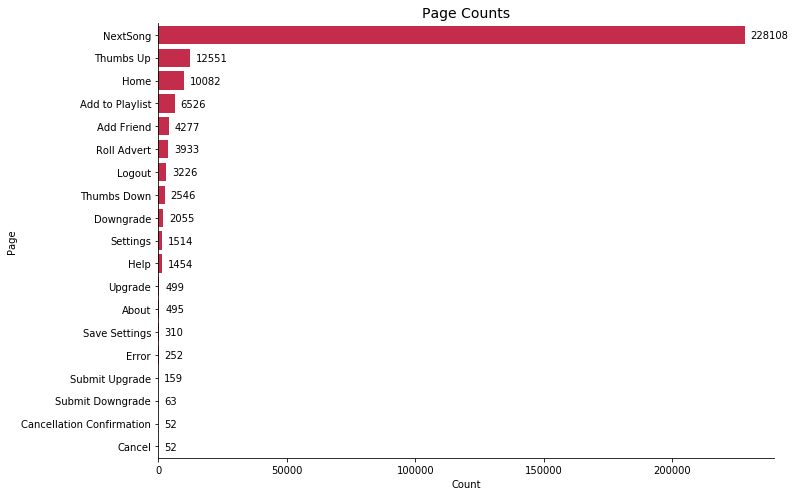

In [17]:
# Retrieve counts of events
page_counts = pd.DataFrame(
    df.groupBy('page').count().collect(), columns=["page", "page_count"]
    ).sort_values(by='page_count', ascending=False).reset_index()

# Instantiate plot
fig, ax = plt.subplots(1, 1, figsize=(11, 7))

# Plot bar chart
sns.barplot(data=page_counts, y='page', x='page_count', ax=ax, color='crimson')

# Annotate with count values
max_count = page_counts['page_count'].max()
for i, v in page_counts.iterrows():
    label = v.page_count
    ax.text(v.page_count+(max_count*0.01), i+0.15, label, color='black')

# Format chart
ax.set_ylabel("Page")
ax.set_xlabel("Count")
ax.set_title("Page Counts", fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

The above bar chart conveys lot of things.

1. Not many users in the dataset have churned as there are only 52 cancellation confirmations.
2. Skipping the track is the most popular thing users do. This could mean user not liking the content and indicate churn. So we have to include this factor in our model later.
3. There is lot of skew in the data. This could be because the data is sampled from a larger set and the distribution is not captured correctly.
4. I am going to consider the following events as an indication of churn. Later, we build features based on these events.
   - Thumbs up and Thumbs down events could indicate user interaction with the app.
   - When users like the content, they add the songs to a playlist and users will stay longer from changing plans as they would lose their playlist.
   - Sharing about the app to your friends and adding them to the app could be big a net promoter indicator.
   - Visiting help pages and facing error messages can make users dislike the app


Now, we will include churn columns into our analysis. We can check usage and behaviour of churned users as compared to the loyal ones!

In [18]:
#listening time of churned and non-churned users
df.groupBy('churn').avg('length').show()

+-----+------------------+
|churn|       avg(length)|
+-----+------------------+
|    1|248.63279564406218|
|    0|249.20913538880816|
+-----+------------------+



Average listening time of both categories is the same. So, we do not have to worry about this feature.

In [21]:
df.where('page="NextSong"')\
    .select(['userId', 'churn']).distinct()\
    .groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



The above query actually looks into the next song event and clubs all those events into one and compares churn and non-churned users. There is no interesting pattern here so I ignore this feature for my modelling.

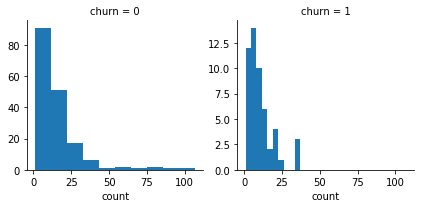

In [23]:
session_df = df.select('userId', 'churn', 'sessionId')\
        .distinct().groupBy(['userId', 'churn']).count().toPandas()

# compare two groups of users
grid = sns.FacetGrid(session_df, col="churn", sharey=False)
grid.map(plt.hist, "count");

The number of sessions for churned users is very less which means loyal users do not churn.

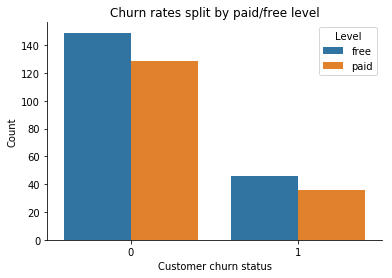

In [24]:
level_churn = df.dropDuplicates(["userId", "level"])\
        .groupby(["churn", "level"]).count().sort("churn").toPandas()

ax = sns.barplot(x='churn', y='count', hue='level', data=level_churn)
plt.xlabel('Customer churn status')
plt.ylabel('Count')
plt.legend(title='Level', loc='best')
plt.title('Churn rates split by paid/free level')
sns.despine(ax=ax);

From the above comparison bar chart, it is interesting to see the free tier users are cancelling more than paid tier users.

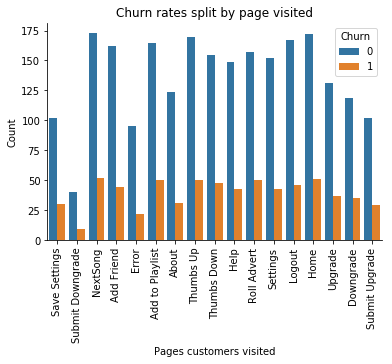

In [25]:
df_filtered = df.filter((df.page != 'Cancel') &(df.page != 'Cancellation Confirmation'))
page_churn = df_filtered.dropDuplicates(["userId", "page"])\
        .groupby(["churn", "page"]).count().sort("churn").toPandas()

ax = sns.barplot(x='page', y='count', hue='churn', data=page_churn)
plt.xlabel('Pages customers visited')
plt.ylabel('Count')
plt.legend(title='Churn', loc='upper right')
plt.title('Churn rates split by page visited')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.despine(ax=ax);

The above graph clearly indicates very less number of churned users in the dataset. This means we cannot completely believe the churned users behaviour. However, non-churned users give us lot of information. We could always learn from the behaviour of current users and work on improvements for users.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

We will next engineer a new dataframe for the modelling part based on each unique user of the application. The reason behind creating these features is based on the data exploration we did above. Following are the features we would create in the method below.


- Number of total songs a user has listened to (total_songs)
- Paid subscription (paid_tier)
- Free subscription (free_tier)
- Average number of songs listened to by a user (avg_songs_per_session)
- Number of visits to a help page (help_visits)
- Number of times a user has added a song to playlist (add_to_playlist)
- Subscription Lifetime of a customer (lifetime)
- Number of errors encountered  (errors_faced)
- Number of friends added (friends_added_count)
- Number of thumbs up event (thumbs_up_count)
- Number of thumbs down event (thumbs_down_count)
- User churn based on the cancellation confirmation event (label)

In [28]:
def feature_engineer(df):
    '''
    Engineer a dataframe which accumulates different events based on userId
    
    INPUT: df - original log events dataframe loaded from S3 bucket
    
    OUTPUT: data - engineered dataframe based on unique users
    '''
    #clean the dataset
    df = df.filter(df['userId'] != '')
    df = df.dropna(how = "any", subset = ["userId", "sessionId"])
    
    #define churn events
    flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
    flag_churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
    
    #mark downgrade and churn event on each activity
    df = df.withColumn("downgrade_event", flag_downgrade_event("page"))\
            .withColumn("cancellation_event", flag_churn_event("page"))
    
    #label churn and downgrade event upon users
    user_frame = Window.partitionBy('userId')
    df = df.withColumn('downgrade', max('downgrade_event').over(user_frame)) \
            .withColumn('churn', max('cancellation_event').over(user_frame))
    
    #engineer features for modelling
    
    #udfs for engineering columns 
    free = udf(lambda x: int(x=='free'), IntegerType())
    paid = udf(lambda x: int(x=='paid'), IntegerType())
    get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000), DateType())
    
    #generating featuring grouped by users
    total_songs_listened = df \
        .select('userID','song') \
        .groupBy('userID') \
        .count() \
        .withColumnRenamed('count', 'total_songs')
    
    thumbs_up_count = df \
        .select('userID','page') \
        .where(df.page == 'Thumbs Up') \
        .groupBy('userID') \
        .count() \
        .withColumnRenamed('count', 'thumbs_up_count') 

    thumbs_down_count = df \
        .select('userID','page') \
        .where(df.page == 'Thumbs Down') \
        .groupBy('userID') \
        .count() \
        .withColumnRenamed('count', 'thumbs_down_count')
    
    friends_added = df.filter(df.page=='Add Friend')\
        .select('userId', 'page')\
        .groupBy('userId').count()\
        .withColumnRenamed('count', 'friends_added_count')
    
    errors_encountered = df.filter(df.page=='Error')\
        .select('userId', 'page', 'ts', 'length')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'})\
        .groupBy('userId').mean()\
        .withColumnRenamed('avg(count(page))', 'errors_faced')
    
    customer_lifetime = df \
        .select('userId','registration','ts') \
        .withColumn('lifetime',(df.ts-df.registration)) \
        .groupBy('userId') \
        .agg({'lifetime':'max'}) \
        .withColumnRenamed('max(lifetime)','lifetime') \
        .select('userId', (col('lifetime')/1000/3600/24).alias('lifetime'))
    
    playlist_creation = df \
        .select('userID','page') \
        .where(df.page == 'Add to Playlist') \
        .groupBy('userID') \
        .count() \
        .withColumnRenamed('count', 'add_to_playlist')
    
    help_visits = df.filter(df.page=='Help')\
        .select('userId', 'page', 'ts', 'length')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'})\
        .groupBy('userId').mean()\
        .withColumnRenamed('avg(count(page))', 'help_visits')
    
    avg_songs_per_session = df.where('page == "NextSong"') \
        .groupby(['userId', 'sessionId']) \
        .count() \
        .groupby(['userId']) \
        .agg({'count':'avg'}) \
        .withColumnRenamed('avg(count)', 'avg_songs_per_session')
    
    user_level = df.select('userId', 'level')\
        .where((df.level=='free')|(df.level=='paid'))\
        .dropDuplicates()\
        .withColumn('free_tier', free('level'))\
        .withColumn('paid_tier', paid('level')).drop('level')
    
    label = df \
        .select('userId', col('churn').alias('label'))\
        .dropDuplicates()
    
    #create new dataframe to be used for modelling
    data = total_songs_listened.join(label, on='userId')\
        .join(user_level, on='userId')\
        .join(avg_songs_per_session, on='userId')\
        .join(help_visits, on='userId')\
        .join(playlist_creation, on='userId')\
        .join(customer_lifetime, on='userId')\
        .join(errors_encountered, on='userId')\
        .join(friends_added, on='userId')\
        .join(thumbs_down_count, on='userId')\
        .join(thumbs_up_count, on='userId')\
        .drop('userId')
    
    return data

In [29]:
df = feature_engineer(df)
df.take(2)

[Row(total_songs=2464, label=1, free_tier=0, paid_tier=1, avg_songs_per_session=211.1, help_visits=1.7142857142857142, add_to_playlist=52, lifetime=19.455844907407407, errors_faced=1.0, friends_added_count=28, thumbs_down_count=21, thumbs_up_count=100),
 Row(total_songs=4825, label=0, free_tier=0, paid_tier=1, avg_songs_per_session=145.67857142857142, help_visits=1.4375, add_to_playlist=118, lifetime=131.55591435185184, errors_faced=1.2, friends_added_count=74, thumbs_down_count=41, thumbs_up_count=171)]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [30]:
def feature_scale(df):
    '''
    Vectorise and scale the required features and returns the transformed data
    
    INPUT: df - feature enigneered dataframe
    OUTPUT: data - transformed features as a dataframe
    '''
    #vectorise features without the label column
    features = df.drop('label').columns
    assembler = VectorAssembler(inputCols=features, outputCol="NumFeatures")
    data=assembler.transform(df)
    
    #scale the data with standard deviation
    scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
    scalerModel = scaler.fit(data)
    data = scalerModel.transform(data)
    
    return data

In [31]:
data = feature_scale(df)
data.take(2)

[Row(total_songs=2464, label=1, free_tier=0, paid_tier=1, avg_songs_per_session=211.1, help_visits=1.7142857142857142, add_to_playlist=52, lifetime=19.455844907407407, errors_faced=1.0, friends_added_count=28, thumbs_down_count=21, thumbs_up_count=100, NumFeatures=DenseVector([2464.0, 0.0, 1.0, 211.1, 1.7143, 52.0, 19.4558, 1.0, 28.0, 21.0, 100.0]), features=DenseVector([1.6104, 0.0, 1.9953, 5.3986, 3.7338, 1.3773, 0.4916, 4.0415, 1.1572, 1.4057, 1.2925])),
 Row(total_songs=4825, label=0, free_tier=0, paid_tier=1, avg_songs_per_session=145.67857142857142, help_visits=1.4375, add_to_playlist=118, lifetime=131.55591435185184, errors_faced=1.2, friends_added_count=74, thumbs_down_count=41, thumbs_up_count=171, NumFeatures=DenseVector([4825.0, 0.0, 1.0, 145.6786, 1.4375, 118.0, 131.5559, 1.2, 74.0, 41.0, 171.0]), features=DenseVector([3.1534, 0.0, 1.9953, 3.7255, 3.1309, 3.1255, 3.3238, 4.8498, 3.0582, 2.7445, 2.2102]))]

In [32]:
#allocate 60% for training and 20% each for validation and testing
train, rest = data.randomSplit([0.6, 0.4], seed=42)
validation, test = rest.randomSplit([0.5,0.5], seed=42)

In [33]:
def train_and_evaluate_model(classifier):
    '''
    Trains the data using cross validator with a param grid and evaluate the data using F1 score
    The method also calculates time for training and accuracy
    
    Input: classfier - initialised classifier variable for cross validator
    
    '''
    f1 = MulticlassClassificationEvaluator(metricName='f1')
    param_grid = ParamGridBuilder().build()
    cross_validator = CrossValidator(estimator=classifier,
                          evaluator=f1, 
                          estimatorParamMaps=param_grid,
                          numFolds=3)
    start = time()
    model = cross_validator.fit(train)
    end = time()
    model.avgMetrics
    print('The training process took {} seconds'.format(end - start))
    results = model.transform(validation)
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    print('Metrics:')
    print('Accuracy: {}'.format(evaluator.evaluate(results, {evaluator.metricName: "accuracy"})))
    print('F-1 Score:{}'.format(evaluator.evaluate(results, {evaluator.metricName: "f1"})))

Since we have label column to classify/predict, let us train our model with three classifiers: 
As it is a simple case of predicting if a set of variable class or not, we first look at Logistic Regression.

Then, as we have continuous and categorical variables, we choose two popular decision tree classifiers such as Gradient Boosted Trees(GBT) and RandomForestClassifier.

In [34]:
lr = LogisticRegression(maxIter=10)
train_and_evaluate_model(lr)

The training process took 492.47389030456543 seconds
Metrics:
Accuracy: 0.7368421052631579
F-1 Score:0.6640795537230172


In [35]:
gbt = GBTClassifier(maxIter=10,seed=42)
train_and_evaluate_model(gbt)

The training process took 1284.7099123001099 seconds
Metrics:
Accuracy: 0.9473684210526315
F-1 Score:0.9459507354244197


In [36]:
rf = RandomForestClassifier(numTrees=10)
train_and_evaluate_model(rf)

The training process took 430.53546142578125 seconds
Metrics:
Accuracy: 0.8947368421052632
F-1 Score:0.8879699248120301


#### Choosing the best model

From the above results, Logistic Regression does not have a good F1 score.

Out of the three classifiers, Gradient Boosting Trees(GBT) classifier has an accuracy and F1 score of 94%. Hence, we will fit the same model without cross validator. 

We will do this to explore the methods inside GBT model such as feature importance. This will give us an idea of what features are very important for a user to churn.

In [37]:
gbt = GBTClassifier(maxIter=10,seed=42)
gbt_model = gbt.fit(train)
results_final = gbt_model.transform(test)

In [44]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_final, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_final, {evaluator.metricName: "f1"})))

Metrics:
Accuracy: 0.9285714285714286
F-1 Score:0.9360119047619048


In [42]:
# Feature importance
feature_ind = gbt_model.featureImportances.indices.tolist()
features = df.drop('label').columns
feature_name = [features[ind] for ind in feature_ind]
feature_coef = gbt_model.featureImportances.values.tolist()
print(feature_name)
print()
print(feature_coef)

['total_songs', 'avg_songs_per_session', 'help_visits', 'add_to_playlist', 'lifetime', 'errors_faced', 'friends_added_count', 'thumbs_down_count', 'thumbs_up_count']

[0.20183923212402086, 0.1754304535264815, 0.18872370914437794, 0.028383743466587695, 0.15480108826452557, 0.012797960255266545, 0.06418630404437344, 0.1558705485076221, 0.017966960666744324]


#### Conclusion

When GBT is tested over the testing dataset, we get the accuracy around 92% and F1 score of 93%. Hence, the model is performing well with this dataset. The only drawback is the time(resources) taken to train this model. This is because of the nature of Gradient Boosted Trees which runs iteratively to minimize the loss function. Since, this is a small subset of the big dataset, I still choose to go with Gradient Boosted Trees.

Regarding our problem of predicting the churn of users, it would be better for the company to look into the important features derived from GBTs such as total songs listened, thumbs up event and minimizing help page visits or giving good help articles would actually prevent the users from churning.


##### Improvement
Since GBTs have a tendency to overfit, I would want to confirm the accuracy with the much bigger dataset. If overfitting is the case, the next resort would be Random Forest Classifier which has 89% accuracy and much less time to train than GBTs. As a result, in order to confirm my assumptions, it is good to train with a big dataset.

Also, when it comes to predicting churn for music apps, it would also be good to consider time pattern of app usage. For example, at what time, day, or part of the year users use the app a lot. When the log data is given for an entire year, this information would be much more useful for predicting churn.


##### Reflection
This project had a steep learning curve. I got to implement all things I have learned so far in my course. On top of that, I got to work on Spark which is used for real world problems of Big Data. Spark initially was difficult for me because of the syntax compared to Pandas and Sklearn library. Later, when I hosted the script in AWS EMR cluster to train GBT classifier, I understood the importance of RDDs and got familiarised with Spark syntax.

Finally, I would like to acknowledge Udacity for the great materials provided throughout this nanodegree and the extra curricular lessons. Most of the pyspark ml code is adopted from additional Spark lessons. In addtion to that, following links helped me in doing this project.

References:

1.https://knockdata.github.io/spark-window-function/

2.https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

3.https://stackabuse.com/gradient-boosting-classifiers-in-python-with-scikit-learn/

4.https://spark.apache.org/docs/2.2.0/ml-classification-regression.html#gradient-boosted-trees-gbts

5.https://stackabuse.com/gradient-boosting-classifiers-in-python-with-scikit-learn/


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.